In [37]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [38]:
from data_generation import *
from utils import *
from upscaling import UpScale
from scipy.linalg import sqrtm

In [212]:
# Hyperparameters initialisation

N_low = 20
N_high = 100
batch_size = 32

# Parameters for Langevin dynamics
K = 60
s = 0.0001

# Parameters for GP
GP_l = 0.1
GP_sigma = 0.1

# Variance of likelihood distribution of u_h
ll_sigma = 0.01

epoch_num = 1000

In [40]:
# Generate the mean of low_res and high_res solution
w_low, r_low, A_low, x_low, y_low = generate_data(N_low)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high)

# Generate mean and varaince of u_low_prior
mean_u, covariance_u = u_low_prior(GP_l,GP_sigma,N_low)

In [41]:
with h5py.File('data/high_res_500.h5', 'r') as hf:
    data = hf['high_res_GP'][:]
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.tensor(data.reshape(500,1,100,100))
data = data.to(torch.float32).to(device)
trainset = torch.utils.data.DataLoader(dataset=data,batch_size=batch_size,shuffle=False)

In [42]:
def sqrt_matrix(M):
    """
    Work out square root of a positive definite matrix
    """
    return sqrtm(M.cpu().data.numpy())
   
covariance = torch.tensor(covariance_u).to(device).to(torch.float32)
positive_covariance = covariance + 1e-5 * torch.eye(400).to(device)
sqrt_covariance = torch.tensor(sqrt_matrix(positive_covariance)).to(device).to(torch.float32)

In [190]:
def sample_p_data():
    return data[torch.LongTensor(batch_size).random_(0,500)].detach()

def sample_p_0(batch_size):
    # Randomly sampling for initialisation of the Langevin dynamics
    # prior = torch.randn(*[batch_size,1,20,20]).to(device)
    
    # Set the u_low_mean to the initialisation of the Langevin dynamics
    mean = w_low.reshape(1,1,N_low,N_low)
    b = np.repeat(mean,batch_size,axis=0)
    prior = torch.tensor(b).to(device).to(torch.float32)
    prior = prior + 0.1 * torch.rand_like(prior)
    
    return prior

def calculate_log_likelihood(x_hat,x,batch_size):
    ll = -1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(batch_size,1,N_high**2),(x-x_hat).reshape(batch_size,N_high**2,1))
    # ll = -1/(2*math.pow(ll_sigma, 2)) * mse(x_hat,x)
    # ll = -torch.norm(x - x_hat, dim=-1) ** 2. / (2. * ll_sigma ** 2.)
    return ll.sum()
       
    
def ula_posterior(z, x, G):
    """
    Langevin dynamics without preconditioner
    """
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []
    for i in range(K):
        # Grad log-likelihood
        x_hat = G(z)
        log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
        grad_log_likelihood = torch.autograd.grad(log_likelihood, z)[0]
        
        # Grad prior
        w_low_tensor = torch.tensor(w_low).to(device).to(torch.float32)
        difference = z.reshape(batch_size,1,N_low**2) - w_low_tensor.reshape(1,N_low**2)
        grad_log_prior = -torch.linalg.solve(covariance, difference.reshape(batch_size,400,1)).reshape(batch_size,1,N_low,N_low)
        
        # Random noise term
        W = torch.randn(*[batch_size,1,N_low,N_low]).to(device)
        
        z = z + s**2 * grad_log_prior + s**2 * grad_log_likelihood + torch.sqrt(torch.tensor(2.)) * s * W
        chains_evolution.append(z.cpu().data.numpy())   
           
    return z.detach(), chains_evolution


def ula_posterior_preconditioner(z, x, G):
    """
    Langevin dynamics with preconditioner
    """
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []
    preconditioner = covariance
    for i in range(K):
        # Grad log-likelihood
        x_hat = G(z)
        log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]
        grad_log_likelihood = torch.matmul(preconditioner,grad_ll.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)
        
        # Grad prior
        w_low_tensor = torch.tensor(w_low).to(device).to(torch.float32)
        difference = z.reshape(batch_size,1,N_low**2) - w_low_tensor.reshape(1,N_low**2)
        grad_log_prior = - difference.reshape(batch_size,1,N_low,N_low)
        
        # Random noise term
        W = torch.randn(*[batch_size,1,N_low,N_low]).to(device)
        random = torch.matmul(sqrt_covariance,W.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)
        
        z = z + s**2 * grad_log_prior + s**2 * grad_log_likelihood + torch.sqrt(torch.tensor(2.)) * s * random
        chains_evolution.append(z.cpu().data.numpy())   
           
    return z.detach(), chains_evolution

### Check whether Langevin works

In [234]:
G = UpScale()
# Load an already trained upscaling network
G.load_state_dict(torch.load('models/best_2D_model_nonprob.pth'))
G = G.to(device)
mse = nn.MSELoss(reduction='sum')

x = sample_p_data()
posterior_initial = sample_p_0(batch_size)
# posterior_final, posterior_chain = ula_posterior(posterior_initial, x, G)
posterior_final, posterior_chain = ula_posterior_preconditioner(posterior_initial, x, G)

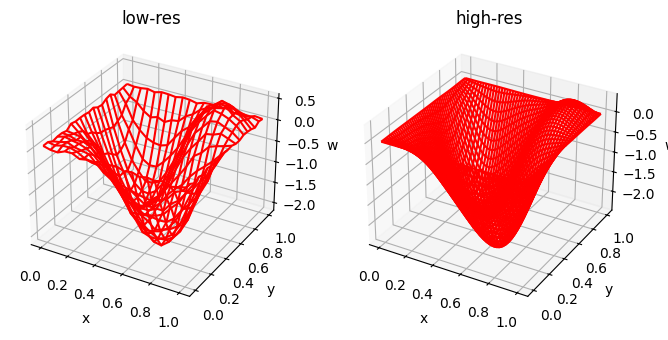

In [235]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, posterior_chain[-1][3][0],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, x.detach().cpu()[3][0].reshape(100,100),color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [213]:
x = sample_p_data()
z = sample_p_0(batch_size)
z = z.clone().detach().requires_grad_(True)

In [232]:
x_hat = G(z)
log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
grad_ll = torch.autograd.grad(log_likelihood, z)[0]
grad_log_likelihood = torch.matmul(covariance,grad_ll.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)

# Grad prior
w_low_tensor = torch.tensor(w_low).to(device).to(torch.float32)
difference = z.reshape(batch_size,1,N_low**2) - w_low_tensor.reshape(1,N_low**2)
grad_log_prior = - difference.reshape(batch_size,1,N_low,N_low)

# Random noise term
W = torch.randn(*[batch_size,1,N_low,N_low]).to(device)
random = torch.matmul(sqrt_covariance,W.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)

z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_log_likelihood + s * random

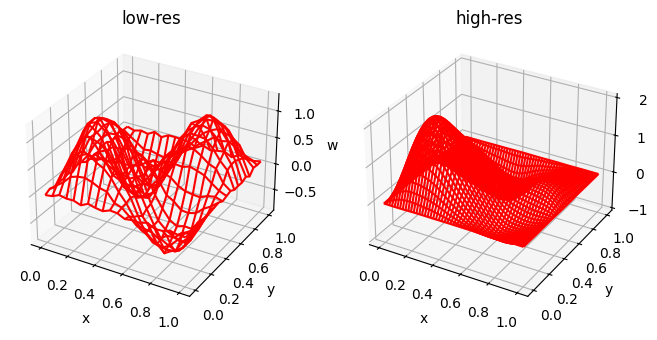

In [233]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy().reshape(32,20,20)[0],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, x.detach().cpu()[0][0].reshape(100,100),color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [113]:
z = sample_p_0(batch_size)
z = z.clone().detach().requires_grad_(True)

In [124]:
x_hat = G(z)
log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
grad_log_likelihood = torch.autograd.grad(log_likelihood, z)[0]

# Grad prior
w_low_tensor = torch.tensor(w_low).to(device).to(torch.float32)
difference = z.reshape(batch_size,1,N_low**2) - w_low_tensor.reshape(1,N_low**2)
grad_log_prior = -torch.linalg.solve(covariance, difference.reshape(batch_size,400,1)).reshape(batch_size,1,N_low,N_low)

# Random noise term
W = torch.randn(*[batch_size,1,N_low,N_low]).to(device)

z = z + 0.5 * s**2 * grad_log_prior + 0.5 * s**2 * grad_log_likelihood + s * W

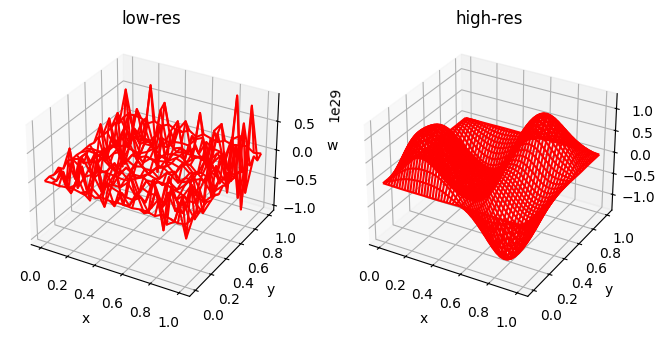

In [125]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy().reshape(100,20,20)[1],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, x.detach().cpu()[1][0].reshape(100,100),color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [236]:
covariance = torch.tensor(covariance_u).to(device).to(torch.float32)
positive_covariance = covariance + 1e-5 * torch.eye(400).to(device)
sqrt_covariance = torch.tensor(sqrt_matrix(positive_covariance)).to(device).to(torch.float32)

In [269]:
import torch
from sqrtm import sqrtm

k = torch.randn(20, 10)
# Create a (hopefully) positive definite matrix
pd_mat = (k.t().matmul(k)).requires_grad_()
covariance = covariance.requires_grad_()
sqrt_mat = sqrtm(covariance)
# sqrt_mat.sum().backward()

In [270]:
positive_covariance

tensor([[1.0010e-02, 8.7066e-03, 5.7464e-03,  ..., 7.9706e-42, 6.3058e-44,
         0.0000e+00],
        [8.7066e-03, 1.0010e-02, 8.7066e-03,  ..., 7.6996e-40, 7.9706e-42,
         6.3058e-44],
        [5.7464e-03, 8.7066e-03, 1.0010e-02,  ..., 5.6386e-38, 7.6996e-40,
         7.9706e-42],
        ...,
        [7.9706e-42, 7.6996e-40, 5.6386e-38,  ..., 1.0010e-02, 8.7066e-03,
         5.7464e-03],
        [6.3058e-44, 7.9706e-42, 7.6996e-40,  ..., 8.7066e-03, 1.0010e-02,
         8.7066e-03],
        [0.0000e+00, 6.3058e-44, 7.9706e-42,  ..., 5.7464e-03, 8.7066e-03,
         1.0010e-02]], device='cuda:0')

In [271]:
torch.matmul(sqrt_mat,sqrt_mat)

tensor([[ 1.0000e-02,  8.7066e-03,  5.7464e-03,  ...,  4.8080e-13,
         -4.5766e-13, -7.0638e-14],
        [ 8.7066e-03,  1.0000e-02,  8.7066e-03,  ...,  1.5633e-13,
         -1.5499e-13, -4.5774e-13],
        [ 5.7464e-03,  8.7066e-03,  1.0000e-02,  ...,  1.1973e-12,
          1.5611e-13,  4.8073e-13],
        ...,
        [ 4.8071e-13,  1.5613e-13,  1.1974e-12,  ...,  1.0000e-02,
          8.7066e-03,  5.7464e-03],
        [-4.5780e-13, -1.5499e-13,  1.5603e-13,  ...,  8.7066e-03,
          1.0000e-02,  8.7066e-03],
        [-7.0666e-14, -4.5769e-13,  4.8078e-13,  ...,  5.7464e-03,
          8.7066e-03,  1.0000e-02]], device='cuda:0', grad_fn=<MmBackward0>)

In [238]:
torch.matmul(sqrt_covariance,sqrt_covariance)

tensor([[ 1.0010e-02,  8.7065e-03,  5.7464e-03,  ..., -8.8456e-09,
         -1.8943e-09,  2.1471e-09],
        [ 8.7069e-03,  1.0010e-02,  8.7065e-03,  ..., -8.7656e-09,
         -4.1090e-09,  2.5413e-12],
        [ 5.7465e-03,  8.7067e-03,  1.0010e-02,  ..., -7.0261e-09,
         -5.7393e-09, -3.4563e-09],
        ...,
        [-4.3511e-09, -2.0030e-09, -1.2421e-08,  ...,  1.0010e-02,
          8.7066e-03,  5.7464e-03],
        [ 1.1220e-09,  9.7942e-10, -5.7940e-09,  ...,  8.7066e-03,
          1.0010e-02,  8.7066e-03],
        [ 3.6267e-09,  3.7963e-09, -6.9573e-09,  ...,  5.7464e-03,
          8.7066e-03,  1.0010e-02]], device='cuda:0')

In [239]:
positive_covariance

tensor([[1.0010e-02, 8.7066e-03, 5.7464e-03,  ..., 7.9706e-42, 6.3058e-44,
         0.0000e+00],
        [8.7066e-03, 1.0010e-02, 8.7066e-03,  ..., 7.6996e-40, 7.9706e-42,
         6.3058e-44],
        [5.7464e-03, 8.7066e-03, 1.0010e-02,  ..., 5.6386e-38, 7.6996e-40,
         7.9706e-42],
        ...,
        [7.9706e-42, 7.6996e-40, 5.6386e-38,  ..., 1.0010e-02, 8.7066e-03,
         5.7464e-03],
        [6.3058e-44, 7.9706e-42, 7.6996e-40,  ..., 8.7066e-03, 1.0010e-02,
         8.7066e-03],
        [0.0000e+00, 6.3058e-44, 7.9706e-42,  ..., 5.7464e-03, 8.7066e-03,
         1.0010e-02]], device='cuda:0')

In [240]:
covariance

tensor([[1.0000e-02, 8.7066e-03, 5.7464e-03,  ..., 7.9706e-42, 6.3058e-44,
         0.0000e+00],
        [8.7066e-03, 1.0000e-02, 8.7066e-03,  ..., 7.6996e-40, 7.9706e-42,
         6.3058e-44],
        [5.7464e-03, 8.7066e-03, 1.0000e-02,  ..., 5.6386e-38, 7.6996e-40,
         7.9706e-42],
        ...,
        [7.9706e-42, 7.6996e-40, 5.6386e-38,  ..., 1.0000e-02, 8.7066e-03,
         5.7464e-03],
        [6.3058e-44, 7.9706e-42, 7.6996e-40,  ..., 8.7066e-03, 1.0000e-02,
         8.7066e-03],
        [0.0000e+00, 6.3058e-44, 7.9706e-42,  ..., 5.7464e-03, 8.7066e-03,
         1.0000e-02]], device='cuda:0')

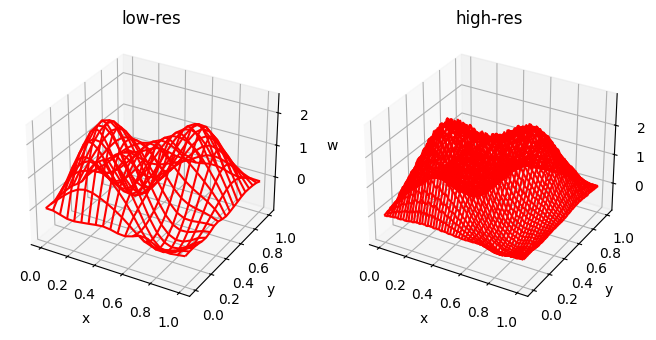

In [31]:
input = np.random.multivariate_normal(mean_u.ravel(),covariance_u)
input = torch.tensor(input.reshape(1,20,20))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, y_input[0],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, y[0], color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [30]:
input = np.random.multivariate_normal(mean_u.ravel(),covariance_u)
input.shape

(400,)

In [25]:
input = np.random.multivariate_normal(mean_u.ravel(),covariance_u)
input.shape

(400,)

In [28]:
y.shape

(1, 2000, 5)

In [23]:
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

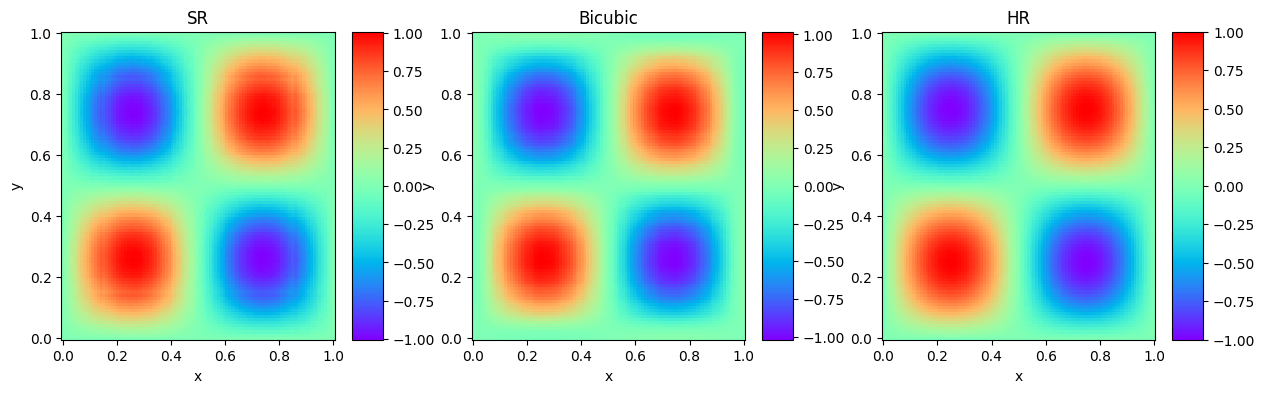

SR L2 Error: 0.00028796141666334656
Bicubic L2 Error: 0.0035608024351483523


In [15]:
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

### Training

In [7]:
# Train with sampled data
G = UpScale()
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = 0.0001, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=60, gamma=0.5)

for epoch in range(1, epoch_num+1):
    
    x = sample_p_data()
    posterior_initial = sample_p_0(batch_size)
    posterior_final, posterior_chain = ula_posterior(posterior_initial, x, G, batch_size)

    optG.zero_grad()
    x_hat = G(posterior_final.detach())
    loss_g = mse(x_hat, x)/batch_size
    # loss_g = (1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x_hat-x).reshape(batch_size,1,10000),(x_hat-x).reshape(batch_size,10000,1))).mean()
    loss_g.backward()
    optG.step()
    
    print("Epoch: {}".format(epoch), "Loss: {}".format(loss_g.item()))

Epoch: 1 Loss: 5711.60791015625
Epoch: 2 Loss: 5049.5
Epoch: 3 Loss: 5059.28759765625
Epoch: 4 Loss: 4606.69384765625
Epoch: 5 Loss: 5204.33203125
Epoch: 6 Loss: 5786.71435546875
Epoch: 7 Loss: 5003.5224609375
Epoch: 8 Loss: 5057.84228515625
Epoch: 9 Loss: 5126.400390625
Epoch: 10 Loss: 4536.17041015625
Epoch: 11 Loss: 4368.7001953125
Epoch: 12 Loss: 5339.75927734375
Epoch: 13 Loss: 4326.537109375
Epoch: 14 Loss: 4831.953125
Epoch: 15 Loss: 4261.20654296875
Epoch: 16 Loss: 4360.4794921875
Epoch: 17 Loss: 4265.177734375
Epoch: 18 Loss: 3595.7373046875
Epoch: 19 Loss: 3124.400390625
Epoch: 20 Loss: 3072.100830078125
Epoch: 21 Loss: 2842.171142578125
Epoch: 22 Loss: 2808.66845703125
Epoch: 23 Loss: 2829.4775390625
Epoch: 24 Loss: 2544.18505859375
Epoch: 25 Loss: 2343.85595703125
Epoch: 26 Loss: 2149.3115234375
Epoch: 27 Loss: 1830.341064453125
Epoch: 28 Loss: 1721.3875732421875
Epoch: 29 Loss: 1751.48486328125
Epoch: 30 Loss: 1591.0775146484375
Epoch: 31 Loss: 1578.701171875
Epoch: 32 Los

KeyboardInterrupt: 

In [17]:
# Train with batch data
G = UpScale()
G = G.to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = 0.0001, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.ExponentialLR(optG, 0.998)
for epoch in range(1, epoch_num+1):
    
    for batch, x in enumerate(trainset,0):
    
        batch_size = x.shape[0]
        posterior_initial = sample_p_0(batch_size)

        posterior_final, posterior_chain = ula_posterior(posterior_initial, x, G, batch_size)

        optG.zero_grad()
        x_hat = G(posterior_final.detach())
        loss_g = mse(x_hat, x)/batch_size
        # loss_g = (1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x_hat-x).reshape(batch_size,1,10000),(x_hat-x).reshape(batch_size,10000,1))).mean()
        loss_g.backward()
        optG.step()
        
        print("Epoch: {}".format(epoch), "Batch: {}".format(batch), "Loss: {}".format(loss_g.item()))

Epoch: 1 Batch: 0 Loss: 3159878656.0
Epoch: 1 Batch: 1 Loss: 225844.890625
Epoch: 1 Batch: 2 Loss: 114728.9765625
Epoch: 1 Batch: 3 Loss: 234658.0625
Epoch: 1 Batch: 4 Loss: 345115.78125
Epoch: 1 Batch: 5 Loss: 438275.0625
Epoch: 1 Batch: 6 Loss: 543467.875
Epoch: 1 Batch: 7 Loss: 392386.6875
Epoch: 1 Batch: 8 Loss: 345176.8125
Epoch: 1 Batch: 9 Loss: 532809.8125
Epoch: 1 Batch: 10 Loss: 543948.375
Epoch: 1 Batch: 11 Loss: 1126188.5
Epoch: 1 Batch: 12 Loss: 2175667.75
Epoch: 1 Batch: 13 Loss: 2193400.75
Epoch: 1 Batch: 14 Loss: 2013075.625
Epoch: 1 Batch: 15 Loss: 2200861.25
Epoch: 2 Batch: 0 Loss: 128658.828125
Epoch: 2 Batch: 1 Loss: 225739.71875
Epoch: 2 Batch: 2 Loss: 114681.7734375
Epoch: 2 Batch: 3 Loss: 234581.359375
Epoch: 2 Batch: 4 Loss: 345014.84375
Epoch: 2 Batch: 5 Loss: 438151.0
Epoch: 2 Batch: 6 Loss: 543336.875
Epoch: 2 Batch: 7 Loss: 392293.53125
Epoch: 2 Batch: 8 Loss: 345135.0
Epoch: 2 Batch: 9 Loss: 532684.5625
Epoch: 2 Batch: 10 Loss: 543815.25
Epoch: 2 Batch: 11 L

KeyboardInterrupt: 

### Testing

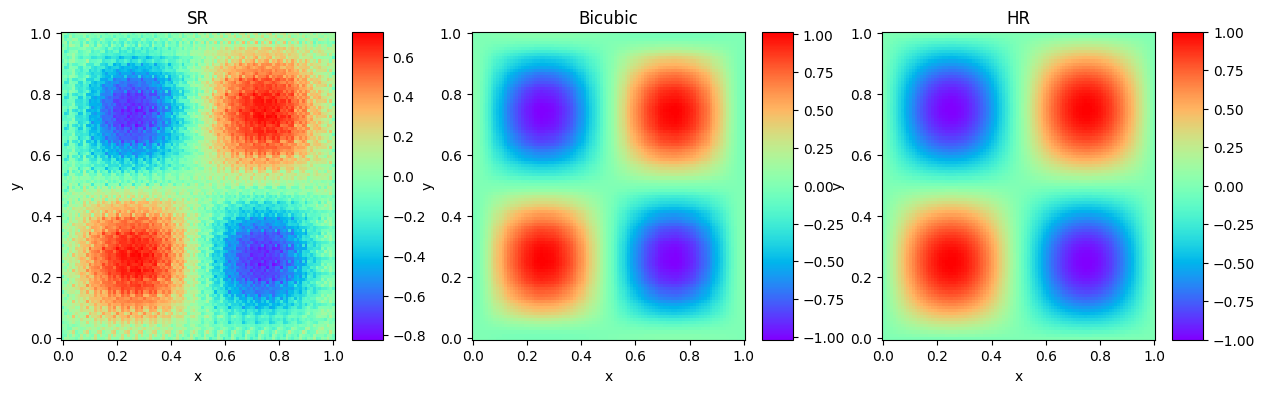

SR L2 Error: 0.029079530900469844
Bicubic L2 Error: 0.0035608024351483523


In [13]:
# Testing
G = UpScale().to(device)
G.load_state_dict(torch.load('best_G.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)